In [2]:
%matplotlib inline

In [3]:
!pip install mxnet-cu101
!pip install gluoncv

     |███████████████████████████████▌| 834.1MB 1.3MB/s eta 0:00:10tcmalloc: large alloc 1147494400 bytes == 0x38fda000 @  0x7f57d05d5615 0x591f47 0x4cc229 0x4cc38b 0x50a51c 0x50c1f4 0x507f24 0x509c50 0x50a64d 0x50c1f4 0x507f24 0x509c50 0x50a64d 0x50cfd6 0x58e793 0x50c467 0x58e793 0x50c467 0x58e793 0x50c467 0x58e793 0x50c467 0x509918 0x50a64d 0x50c1f4 0x507f24 0x509c50 0x50a64d 0x50c1f4 0x509918 0x50a64d
     |████████████████████████████████| 846.0MB 21kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 819kB 13.0MB/s 


In [4]:
import mxnet as mx
import numpy as np
import os, time, shutil
import matplotlib.pyplot as plt
from PIL import Image

from mxnet import gluon, image, init, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
from gluoncv.utils import makedirs
from gluoncv.model_zoo import get_model

# 4. Transfer Learning with Your Own Image Dataset

Dataset size is a big factor in the performance of deep learning models.
``ImageNet`` has over one million labeled images, but
we often don't have so much labeled data in other domains.
Training a deep learning models on small datasets may lead to severe overfitting.

Transfer learning is a technique that addresses this problem.
The idea is simple: we can start training with a pre-trained model,
instead of starting from scratch.
As Isaac Newton said, "If I have seen further it is by standing on the
shoulders of Giants".


In [5]:
import os
from google.colab import files, drive   
import pandas as pd

# mount the google drive to my Colab session
drive.mount('/content/gdrive')
# use the google drive in my Colab session
print(os.listdir('/content/gdrive/My Drive/'))

home_path = '/content/gdrive/My Drive/cs101'

Mounted at /content/gdrive
['cs101', 'Getting started.pdf', 'Colab Notebooks', 'embryo_13_fluo_sequence.mp4', 'embryo_13_fluo_slice.mp4', 'embryo_13_bf_slice.mp4', 'embryo_13_bf_sequence.mp4', 'hi', 'embryo data.gsheet', 'classify_fluo_pretrained.ipynb', 'classify_fluo_CNN_2.ipynb']


In [6]:
# Set window to ignore around polarization
window = 2

# Set aggregation function: middle, avg, max, min
agg_fn = 'avg'

In [7]:
# Fixing the random seed
mx.random.seed(42)
np.random.seed(42)

# Available data
embryo_inds = [1, 3, 12, 13, 16, 18, 19, 24, 39, 40, 42, 45, 46, 47, 49, 50, 52, 53]

# Load info about videos
video_time_info = pd.read_excel(f'{home_path}/video_data_time_info_CS101.xlsx', \
                                index_col=0, header=0, na_values=['NaN','NAN'], \
                                usecols=['usable_index', 'first_pol_time', 't_num'])  
video_time_info.dropna(inplace=True, subset=['first_pol_time'])
print(video_time_info.loc[embryo_inds, 't_num'])

# Directory of the processed *.npy files
processed_path = f'{home_path}/processed'
polar_processed_path = f'{processed_path}/polarization'

p = np.random.permutation(len(embryo_inds))
p_embryo = [embryo_inds[i] for i in p]
t_num = list(video_time_info.loc[embryo_inds, 't_num'])
t_num_random = list(video_time_info.loc[p_embryo, 't_num'])

instance_cum_random = np.cumsum(t_num_random)
test_split_point = instance_cum_random[-1]*0.83
temp = abs(instance_cum_random-test_split_point)
test_idx = np.argmin(temp)

val_split_point = instance_cum_random[-1]*0.7
temp = abs(instance_cum_random-val_split_point)
val_idx = np.argmin(temp)

train_embryos = p_embryo[:val_idx]
val_embryos = p_embryo[val_idx:test_idx]
test_embryos = p_embryo[test_idx:]
print(train_embryos)
print(val_embryos)
print(test_embryos)

# Paths for input data
data_path = f'{processed_path}/fluo_data/{agg_fn}'
pol_path = f'{processed_path}/polarization'
train_path = os.path.join(data_path, f'train_{window}')
val_path = os.path.join(data_path, f'val_{window}')
test_path = os.path.join(data_path, f'test_{window}')

if not os.path.isdir(train_path):
  os.mkdir(train_path)
  os.mkdir(os.path.join(train_path, '0'))
  os.mkdir(os.path.join(train_path, '1'))

if not os.path.isdir(val_path):
  os.mkdir(val_path)
  os.mkdir(os.path.join(val_path, '0'))
  os.mkdir(os.path.join(val_path, '1'))

if not os.path.isdir(test_path):
  os.mkdir(test_path)
  os.mkdir(os.path.join(test_path, '0'))
  os.mkdir(os.path.join(test_path, '1'))

usable_index
1      21.0
3      21.0
12    143.0
13    143.0
16    143.0
18    143.0
19    143.0
24     21.0
39     21.0
40     21.0
42     21.0
45     21.0
46     21.0
47     21.0
49     21.0
50     21.0
52     21.0
53     21.0
Name: t_num, dtype: float64
[1, 3, 39, 18, 13, 47, 52, 50, 45, 12, 40, 53]
[16, 46, 24]
[42, 49, 19]


In [56]:
# Actually create the images

def within_window(embryo_idx, t, window):
    '''
    embryo_idx: index of current embryo (value from 'usable_index' col)
    t: timestep of current
    window: number of t steps from first polarized index to ignore
    '''
    first_pol_idx = video_time_info.loc[embryo_idx, 'first_pol_time'] - 1
    return window and abs(first_pol_idx - t) <= window

def save_nps_as_png(embryos, save_path, window=None):
    '''
    embryos: subset of p_embryo... train, val, test
    save_path: path to save png to... data_path + {'train', 'val', 'test'}
    window: number of t steps from first polarized index to ignore
    '''
    for i in range(len(embryos)):
        embryo_idx = embryos[i]
        embryo_path = f'{data_path}/embryo_{embryo_idx}.npy'
        embryo_pol_path = f'{pol_path}/embryo_{embryo_idx}.npy'
        embryo = np.squeeze(np.load(embryo_path))
        embryo_pol = np.squeeze(np.load(embryo_pol_path)).astype(int)
        embryo = embryo.astype(np.float64) / np.max(embryo) # normalize the data to 0 - 1
        embryo = 255 * embryo # Now scale by 255
        embryo = embryo.astype(np.uint8)
        print(embryo_idx, np.shape(embryo)[2])
        for t in range(np.shape(embryo)[2]):
            if within_window(embryo_idx, t, window):
                print(f'skipping embryo {embryo_idx} step {t}')
                continue
            pol = embryo_pol[t]
            img = Image.fromarray(embryo[:,:,t], 'L')
            img_path = f'{save_path}/{pol}/embryo_{embryo_idx}_{t}.png'
            img.save(img_path)

save_nps_as_png(train_embryos, train_path, window=window)
save_nps_as_png(val_embryos, val_path, window=window)
save_nps_as_png(test_embryos, test_path, window=window)

1 21
skipping embryo 1 step 14
skipping embryo 1 step 15
skipping embryo 1 step 16
skipping embryo 1 step 17
skipping embryo 1 step 18
3 21
skipping embryo 3 step 9
skipping embryo 3 step 10
skipping embryo 3 step 11
skipping embryo 3 step 12
skipping embryo 3 step 13
39 21
skipping embryo 39 step 9
skipping embryo 39 step 10
skipping embryo 39 step 11
skipping embryo 39 step 12
skipping embryo 39 step 13
18 143
skipping embryo 18 step 24
skipping embryo 18 step 25
skipping embryo 18 step 26
skipping embryo 18 step 27
skipping embryo 18 step 28
13 143
skipping embryo 13 step 9
skipping embryo 13 step 10
skipping embryo 13 step 11
skipping embryo 13 step 12
skipping embryo 13 step 13
47 21
skipping embryo 47 step 14
skipping embryo 47 step 15
skipping embryo 47 step 16
skipping embryo 47 step 17
skipping embryo 47 step 18
52 21
skipping embryo 52 step 10
skipping embryo 52 step 11
skipping embryo 52 step 12
skipping embryo 52 step 13
skipping embryo 52 step 14
50 21
skipping embryo 50 s

## Hyperparameters

First, let's import all other necessary libraries.



We set the hyperparameters as following:



In [8]:
classes = 2

epochs = 40
lr = 0.001
per_device_batch_size = 16
momentum = 0.9
wd = 0.0001

lr_factor = 0.75
lr_steps = [10, 20, 30, np.inf]

num_gpus = 1
num_workers = 8
ctx = [mx.gpu(i) for i in range(num_gpus)] if num_gpus > 0 else [mx.cpu()]
batch_size = per_device_batch_size * max(num_gpus, 1)
print(ctx)

[gpu(0)]


Things to keep in mind:

1. ``epochs = 5`` is just for this tutorial with the tiny dataset. please change it to a larger number in your experiments, for instance 40.
2. ``per_device_batch_size`` is also set to a small number. In your experiments you can try larger number like 64.
3. remember to tune ``num_gpus`` and ``num_workers`` according to your machine.
4. A pre-trained model is already in a pretty good status. So we can start with a small ``lr``.

## Data Augmentation

In transfer learning, data augmentation can also help.
We use the following augmentation in training:

2. Randomly crop the image and resize it to 224x224
3. Randomly flip the image horizontally
4. Randomly jitter color and add noise
5. Transpose the data from height*width*num_channels to num_channels*height*width, and map values from [0, 255] to [0, 1]
6. Normalize with the mean and standard deviation from the ImageNet dataset.




In [9]:
transform_train = transforms.Compose([
    transforms.Resize(600, keep_ratio=True),
    transforms.CenterCrop(512),

    transforms.RandomFlipLeftRight(), # Randomly flip the image horizontally
    transforms.RandomFlipTopBottom(),
    transforms.RandomLighting(0.1), # Add AlexNet-style PCA-based noise to an image
    transforms.RandomContrast(0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(600, keep_ratio=True),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


With the data augmentation functions, we can define our data loaders:



In [10]:
train_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(train_path).transform_first(transform_train),
    batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(val_path).transform_first(transform_train),
    batch_size=batch_size, shuffle=True, num_workers = num_workers)

test_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(test_path).transform_first(transform_test),
    batch_size=batch_size, shuffle=False, num_workers = num_workers)

print(len(train_data) + len(val_data) + len(test_data))

58


Note that only ``train_data`` uses ``transform_train``, while
``val_data`` and ``test_data`` use ``transform_test`` to produce deterministic
results for evaluation.

## Model and Trainer

We use a pre-trained ``ResNet50_v2`` model, which has balanced accuracy and
computation cost.



In [17]:
model_name = 'densenet121' #'ResNet50_v2' 
finetune_net = get_model(model_name, pretrained=True)
with finetune_net.name_scope():
    finetune_net.output = nn.Dense(classes)
finetune_net.output.initialize(init.Xavier(), ctx = ctx)
finetune_net.collect_params().reset_ctx(ctx)
finetune_net.hybridize()

trainer = gluon.Trainer(finetune_net.collect_params(), 'sgd', {
                        'learning_rate': lr, 'momentum': momentum, 'wd': wd})
metric = mx.metric.Accuracy()
L = gluon.loss.SoftmaxCrossEntropyLoss()

# Path to save trained models to, create folder
model_save_path = f'{home_path}/models/{model_name}-{agg_fn}-window{window}-batch{per_device_batch_size}-lr{lr}-mom{momentum}-wd{wd}'
if not os.path.isdir(model_save_path):
  os.mkdir(model_save_path)
else:
  print(model_save_path, 'already exists')

100%|██████████| 29622/29622 [00:00<00:00, 47738.58KB/s]


/content/gdrive/My Drive/cs101/models/densenet121-avg-window2-batch16-lr0.001-mom0.9-wd0.0001 already exists


Here's an illustration of the pre-trained model
and our newly defined model:

|image-model|

Specifically, we define the new model by::

1. load the pre-trained model
2. re-define the output layer for the new task
3. train the network

This is called "fine-tuning", i.e. we have a model trained on another task,
and we would like to tune it for the dataset we have in hand.

We define a evaluation function for validation and testing.



In [18]:
def test(net, val_data, ctx):
    metric = mx.metric.Accuracy()
    for i, batch in enumerate(val_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        outputs = [net(X) for X in data]
        metric.update(label, outputs)

    return metric.get()

## Training Loop

Following is the main training loop. It is the same as the loop in
`CIFAR10 <dive_deep_cifar10.html>`__
and ImageNet.

<div class="alert alert-info"><h4>Note</h4><p>Once again, in order to go through the tutorial faster, we are training on a small
    subset of the original ``MINC-2500`` dataset, and for only 5 epochs. By training on the
    full dataset with 40 epochs, it is expected to get accuracy around 80% on test data.</p></div>



In [19]:
lr_counter = 0
num_batch = len(train_data)
train_acc_lst = []
train_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    if epoch == lr_steps[lr_counter]:
        trainer.set_learning_rate(trainer.learning_rate*lr_factor)
        lr_counter += 1

    tic = time.time()
    train_loss = 0
    metric.reset()

    for i, batch in enumerate(train_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        with ag.record():
            outputs = [finetune_net(X) for X in data]
            loss = [L(yhat, y) for yhat, y in zip(outputs, label)]
        for l in loss:
            l.backward()

        trainer.step(batch_size)
        train_loss += sum([l.mean().asscalar() for l in loss]) / len(loss)

        metric.update(label, outputs)

    _, train_acc = metric.get()
    train_loss /= num_batch

    _, val_acc = test(finetune_net, val_data, ctx)

    train_acc_lst.append(train_acc)
    train_loss_lst.append(train_loss)
    val_acc_lst.append(val_acc)
    print('[Epoch %d] Train-acc: %.3f, loss: %.3f | Val-acc: %.3f | time: %.1f' %
             (epoch, train_acc, train_loss, val_acc, time.time() - tic))
    
    # Saving model parameters to file for each epoch
    file_name = f'{model_save_path}/epoch{epoch}.params'
    finetune_net.save_parameters(file_name)

_, test_acc = test(finetune_net, test_data, ctx)
print('[Finished] Test-acc: %.3f' % (test_acc))

[Epoch 0] Train-acc: 0.827, loss: 0.370 | Val-acc: 0.819 | time: 51.4
[Epoch 1] Train-acc: 0.936, loss: 0.135 | Val-acc: 1.000 | time: 34.9
[Epoch 2] Train-acc: 0.952, loss: 0.169 | Val-acc: 1.000 | time: 35.3
[Epoch 3] Train-acc: 0.975, loss: 0.058 | Val-acc: 0.994 | time: 35.0
[Epoch 4] Train-acc: 0.980, loss: 0.043 | Val-acc: 0.982 | time: 35.1
[Epoch 5] Train-acc: 0.963, loss: 0.081 | Val-acc: 0.994 | time: 35.1
[Epoch 6] Train-acc: 0.984, loss: 0.033 | Val-acc: 0.994 | time: 35.2
[Epoch 7] Train-acc: 0.971, loss: 0.064 | Val-acc: 0.977 | time: 35.0
[Epoch 8] Train-acc: 0.982, loss: 0.044 | Val-acc: 0.994 | time: 35.0
[Epoch 9] Train-acc: 0.995, loss: 0.102 | Val-acc: 0.977 | time: 35.1
[Epoch 10] Train-acc: 0.995, loss: 0.141 | Val-acc: 0.982 | time: 35.2
[Epoch 11] Train-acc: 0.998, loss: 0.006 | Val-acc: 0.988 | time: 35.0
[Epoch 12] Train-acc: 0.993, loss: 0.049 | Val-acc: 0.982 | time: 35.1
[Epoch 13] Train-acc: 0.995, loss: 0.017 | Val-acc: 0.977 | time: 35.1
[Epoch 14] Train

1


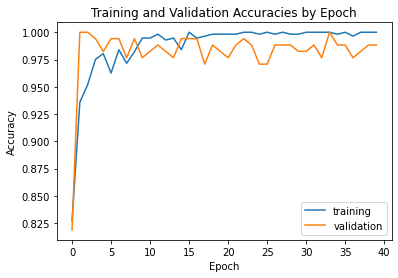

In [20]:
# Plot training with validation
plt.plot(range(epochs), train_acc_lst, label='training')
plt.plot(range(epochs), val_acc_lst, label='validation')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracies by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

print(np.argmax(val_acc_lst))

In [21]:
# Loading best model parameters from file
best_epoch = 16
best_model_file_name = f'{model_save_path}/epoch{best_epoch}.params'
finetune_net.load_parameters(best_model_file_name, ctx=ctx)
# run on test data
_, test_acc = test(finetune_net, test_data, ctx)
print('[Finished] Test-acc: %.3f' % (test_acc))

[Finished] Test-acc: 0.808


## Next

Now that you have learned to muster the power of transfer
learning, to learn more about training a model on
ImageNet, please read `this tutorial <dive_deep_imagenet.html>`__.

The idea of transfer learning is the basis of
`object detection <../examples_detection/index.html>`_ and
`semantic segmentation <../examples_segmentation/index.html>`_,
the next two chapters of our tutorial.

.. |image-minc| image:: https://raw.githubusercontent.com/dmlc/web-data/master/gluoncv/datasets/MINC-2500.png
.. |image-model| image:: https://zh.gluon.ai/_images/fine-tuning.svg

